In [5]:
from modules.oas_model import *

### Assume SMMs identical during first 33 months and solve for SMM such that factor is 0.64702083

In [6]:
smm = factor_to_smm(factor=0.64702083)
smm

np.float64(0.010558411631716622)

In [7]:
pool1 = PoolOAS(maturity=358, wac=0.04075, wala=33, smm=smm, init_principal=1030969748038)

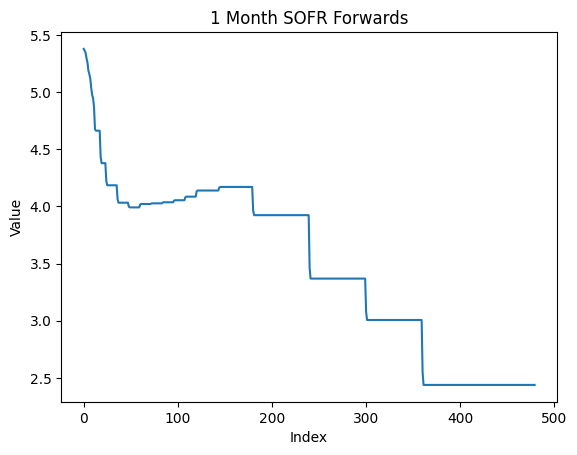

In [12]:
base_case = pd.read_csv('../data/libor_forward.csv', skiprows=1)['Forward Rate']

plt.plot(base_case)
plt.title("1 Month SOFR Forwards")
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [13]:
forward_140_cpr = pd.read_csv('../data/forward-140_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward_120_cpr = pd.read_csv('../data/forward-120_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward_100_cpr = pd.read_csv('../data/forward-100_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward_80_cpr = pd.read_csv('../data/forward-80_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward_60_cpr = pd.read_csv('../data/forward-60_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward_40_cpr = pd.read_csv('../data/forward-40_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward_20_cpr = pd.read_csv('../data/forward-20_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward0_cpr = pd.read_csv('../data/forward0_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward20_cpr = pd.read_csv('../data/forward20_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward40_cpr = pd.read_csv('../data/forward40_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward60_cpr = pd.read_csv('../data/forward60_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward80_cpr = pd.read_csv('../data/forward80_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward100_cpr = pd.read_csv('../data/forward100_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward120_cpr = pd.read_csv('../data/forward120_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)
forward140_cpr = pd.read_csv('../data/forward140_cpr.csv', skiprows=1).iloc[:,1].dropna().reset_index(drop=True)

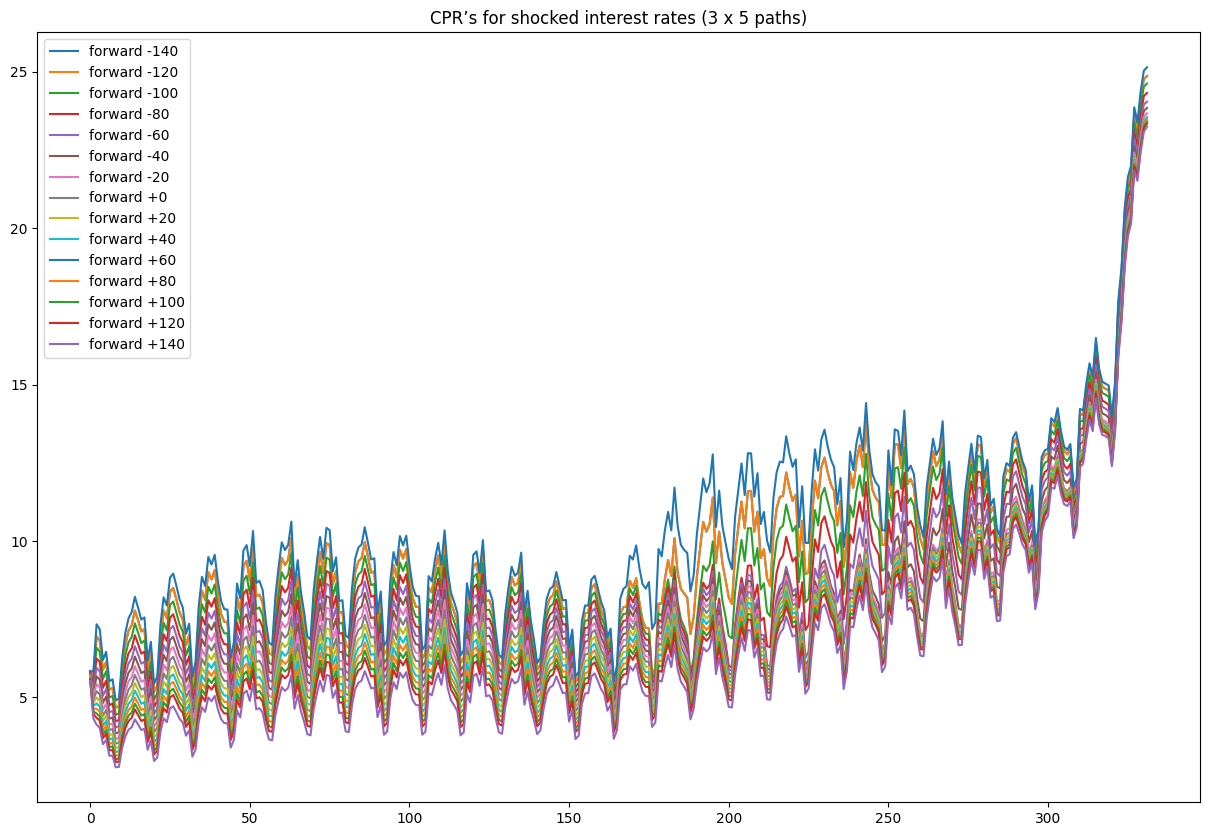

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(forward_140_cpr, label='forward -140')
plt.plot(forward_120_cpr, label='forward -120')
plt.plot(forward_100_cpr, label='forward -100')
plt.plot(forward_80_cpr, label='forward -80')
plt.plot(forward_60_cpr, label='forward -60')
plt.plot(forward_40_cpr, label='forward -40')
plt.plot(forward_20_cpr, label='forward -20')
plt.plot(forward0_cpr, label='forward +0')
plt.plot(forward20_cpr, label='forward +20')
plt.plot(forward40_cpr, label='forward +40')
plt.plot(forward60_cpr, label='forward +60')
plt.plot(forward80_cpr, label='forward +80')
plt.plot(forward100_cpr, label='forward +100')
plt.plot(forward120_cpr, label='forward +120')
plt.plot(forward140_cpr, label='forward +140')
plt.title("CPR’s for shocked interest rates (3 x 5 paths)")
plt.legend()
plt.show()

### Calculate the WAL each month through time for each path

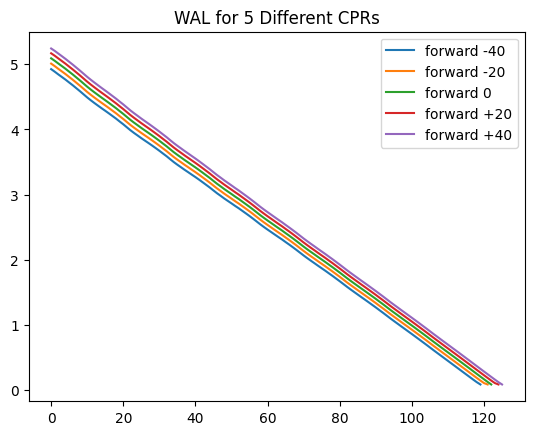

In [16]:
pt1 = PassthroughOAS(fee=0.00575).feed(pool1)
pt1.cpr(forward_40_cpr)
pt2 = PassthroughOAS(fee=0.00575).feed(pool1)
pt2.cpr(forward_20_cpr)
pt3 = PassthroughOAS(fee=0.00575).feed(pool1)
pt3.cpr(forward0_cpr)
pt4 = PassthroughOAS(fee=0.00575).feed(pool1)
pt4.cpr(forward20_cpr)
pt5 = PassthroughOAS(fee=0.00575).feed(pool1)
pt5.cpr(forward40_cpr)

plt.plot(pt1.PassthroughRefi['WAL'], label='forward -40')
plt.plot(pt2.PassthroughRefi['WAL'], label='forward -20')
plt.plot(pt3.PassthroughRefi['WAL'], label='forward 0')
plt.plot(pt4.PassthroughRefi['WAL'], label='forward +20')
plt.plot(pt5.PassthroughRefi['WAL'], label='forward +40')

plt.title("WAL for 5 Different CPRs")
plt.legend()
plt.show()

### Solve for the OAS

In [21]:
price = 86 + 7 / 32

cf1 = pt1.PassthroughRefi['ActualPymt']
r1 = base_case - 0.0004
cf2 = pt2.PassthroughRefi['ActualPymt']
r2 = base_case - 0.0002
cf3 = pt3.PassthroughRefi['ActualPymt']
r3 = base_case
cf4 = pt4.PassthroughRefi['ActualPymt']
r4 = base_case + 0.0002
cf5 = pt5.PassthroughRefi['ActualPymt']
r5 = base_case + 0.0004

curr_bal = pt1.PassthroughRefi['BeginPrincipal'].iloc[0]

def oas_objective_func(spread):
    pv_val = 0
    pv_val += pv(cf1, r1, spread)
    pv_val += pv(cf2, r2, spread)
    pv_val += pv(cf3, r3, spread)
    pv_val += pv(cf4, r4, spread)
    pv_val += pv(cf5, r5, spread)

    return price / 100 * curr_bal - pv_val / 5
# Perform optimization
result = fsolve(oas_objective_func, 0.01)

# Extract the optimized parameters
oas = result[0]

# Print the result
print("oas:", oas)


oas: 0.031241561543400086


## 2. Assuming CPRs do not change when rates are shocked, calculate

In [23]:
pt = PassthroughOAS(fee=0.00575).feed(pool1)
pt.cpr(forward0_cpr)
cf = pt.PassthroughRefi['ActualPymt']
curr_bal = pt.PassthroughRefi['BeginPrincipal'].iloc[0]

r1 = base_case + 0.0001
r2 = base_case + 0.01
r3 = base_case - 0.01

pv01 =  pv(cf, r1, oas) / curr_bal - price / 100
pv_100 =  pv(cf, r2, oas) / curr_bal - price / 100
pv100 =  pv(cf, r3, oas) / curr_bal - price / 100

print('pv01', pv01)
print('pv -100', pv_100)
print('pv +100', pv100)

pv01 -8.603310982535639e-05
pv -100 -0.00044290199195995417
pv +100 0.0002782694069357605


## 3. Calculate the credit spread sensitivities

In [24]:
pt = PassthroughOAS(fee=0.00575).feed(pool1)
pt.cpr(forward0_cpr)
cf = pt.PassthroughRefi['ActualPymt']
curr_bal = pt.PassthroughRefi['BeginPrincipal'].iloc[0]

r = base_case

cv01 = pv(cf, r, oas + 0.0001) / curr_bal - price / 100
cv100 = pv(cf, r, oas + 0.001) / curr_bal - price / 100
cv_100 = pv(cf, r, oas - 0.001) / curr_bal - price / 100

print('cv01', cv01)
print('cv -100', cv_100)
print('cv +100', cv100)

cv01 -0.00044290199195995417
cv -100 0.0035345536025362945
cv +100 -0.003677213686861802


## 4. Hold OAS constant and calculate chg in PV if rates drop 100bps, rise 100bps

In [25]:
pt = PassthroughOAS(fee=0.00575).feed(pool1)
pt.cpr(forward_60_cpr)
cf_60 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward_80_cpr)
cf_80 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward_100_cpr)
cf_100 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward_120_cpr)
cf_120 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward_140_cpr)
cf_140 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward60_cpr)
cf60 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward80_cpr)
cf80 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward100_cpr)
cf100 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward120_cpr)
cf120 = pt.PassthroughRefi['ActualPymt']

pt.cpr(forward140_cpr)
cf140 = pt.PassthroughRefi['ActualPymt']

curr_bal = pt.PassthroughRefi['BeginPrincipal'].iloc[0]

r1 = base_case - 0.01
r2 = base_case + 0.01

pv_100_60 =  pv(cf_60, r1, oas) / curr_bal - price / 100
pv_100_80 =  pv(cf_80, r1, oas) / curr_bal - price / 100
pv_100_100 =  pv(cf_100, r1, oas) / curr_bal - price / 100
pv_100_120 =  pv(cf_120, r1, oas) / curr_bal - price / 100
pv_100_140 =  pv(cf_140, r1, oas) / curr_bal - price / 100

pv10060 =  pv(cf60, r2, oas) / curr_bal - price / 100
pv10080 =  pv(cf80, r2, oas) / curr_bal - price / 100
pv100100 =  pv(cf100, r2, oas) / curr_bal - price / 100
pv100120 =  pv(cf120, r2, oas) / curr_bal - price / 100
pv100140 =  pv(cf140, r2, oas) / curr_bal - price / 100

print('pv -100 -140', pv_100_140)
print('pv -100 -120', pv_100_120)
print('pv -100 -100', pv_100_100)
print('pv -100 -80', pv_100_80)
print('pv -100 -60', pv_100_60)

print('pv +100 +60', pv10060)
print('pv +100 +80', pv10080)
print('pv +100 +100', pv100100)
print('pv +100 +120', pv100120)
print('pv +100 +140', pv100140)

pv -100 -140 0.010808030571925586
pv -100 -120 0.010808030571925586
pv -100 -100 0.008899970010026959
pv -100 -80 0.007048018288387636
pv -100 -60 0.005265503490647472
pv +100 +60 0.012107297253431404
pv +100 +80 -0.004762561099693419
pv +100 +100 -0.006041247139307315
pv +100 +120 -0.0072502279683202
pv +100 +140 -0.00941837626234343


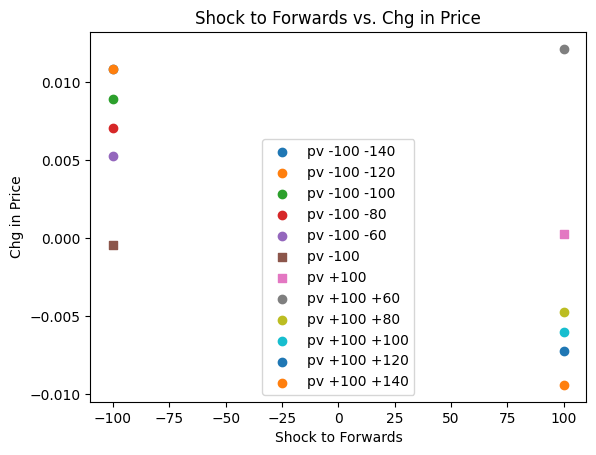

In [26]:
plt.scatter(-100, pv_100_140, label='pv -100 -140')
plt.scatter(-100, pv_100_120, label='pv -100 -120')
plt.scatter(-100, pv_100_100, label='pv -100 -100')
plt.scatter(-100, pv_100_80, label='pv -100 -80')
plt.scatter(-100, pv_100_60, label='pv -100 -60')
plt.scatter(-100, pv_100, marker='s', label='pv -100')

plt.scatter(100, pv100, marker='s', label='pv +100')
plt.scatter(100, pv10060, label='pv +100 +60')
plt.scatter(100, pv10080, label='pv +100 +80')
plt.scatter(100, pv100100, label='pv +100 +100')
plt.scatter(100, pv100120, label='pv +100 +120')
plt.scatter(100, pv100140, label='pv +100 +140')


plt.legend()
plt.xlabel("Shock to Forwards")
plt.ylabel("Chg in Price")
plt.title('Shock to Forwards vs. Chg in Price')
plt.show()

The changes in price are small for #2 because it assumes that the CPRs do not change. In #4, we adopt the changes in the CPRs along the changes in rate. This yields the changes in price according to the changes in the CPRs. As a forward rate and the CPRs increase, the price decreases.

 In #3, it is observable that the price decreases as the oas increases.